<a href="https://colab.research.google.com/github/viniciuswv/AutoML---Classification-of-Electrical-Charges-in-Smart-Grid/blob/main/AutoML_LAMPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

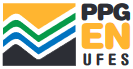

_____
**Programa de Pós-graduação em Energia - PPGEN   |   Universidade Federal do Espírito Santo - UFES**
_____
**As part of the dissertation:** "*Automated adjustment of hyperparameters in convolutional neural network to identify similar electrical loads in smart grid.*"
_____
**Developers:**
Vinicius Wittig Vianna (PPGEN) - viniciuswv@gmail.com;
Wanderley Cardoso Celeste (DCEL/PPGEN) - wanderley.celeste@ufes.br;
Helder Roberto de Oliveira (DEE/PPGEE) - helder.rocha@ufes.br;
Leonardo Jose Silvestre (DCEL) - leonardo.silvestre@ufes.br
_____
This code was developed as a dissertation project by (VIANNA, 2021), for the implementation and investigation of an two stages based optimization for automatically configuring a hyperparameters set of interest in the convolutional neural network (CNN) originally developed in (FIRMES, 2020), whose objective is to classify 16 possible combinations of two types of highly similar electrical charges (lamps and PCs) on a test bench.


**Abstract:**

*  The first step is to apply the Hill Climb(down) optimization, in order to investigate how far it is possible to reduce the data (organized in "cases") while maintaining the network's **test accuracy** greater than or equal to 95%.

*  The second step is to apply the Bayesian optimization, in order to investigate whether it's possible to make the network **valid accuracy** close to 100%, by automatically selecting a good set of hyperparameters.

*  Was necessary to adjust some network learning parameters to improve the robustness and stability during training and validation, otherwise, the Hillclimb optimizer could be stuck in a local minimum.

# 1.Libraries and frameworks import

Import of the necessary tools and verification of the graphics card provided by Google Colab.

In [ ]:
# Canceling miscellaneous cautions:
import warnings
warnings.filterwarnings("ignore")
 
# General modeling in the dataset:
!pip install pandas
import pandas as pd
import numpy as np
import random
import random as python_random
import scipy.io
import time
import datetime
from numpy import array
from decimal import Decimal
from numpy import savetxt
 
# Data pre-processing methods:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
 
# Conversion of vectors into a binary class matrix:
from keras.utils import to_categorical
 
# Indexing of samples for training, validation and test:
from sklearn.model_selection import train_test_split
 
# Neural network architecture (TensorFlow and Keras):
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.callbacks import *
from tensorflow.python.keras.optimizers import *

# Scikit-optimize (2nd stage of optimization):
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
import skopt.plots
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from skopt.callbacks import TimerCallback
 
# Confusion matrix:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools
 
# Plotting tools:
!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker
from keras.utils.vis_utils import plot_model
 
# TensorDash (to check metrics by "TensorDash" Android app):
!pip install tensor-dash
from tensordash.tensordash import Tensordash

     |████████████████████████████████| 102kB 6.9MB/s 


**Verification of the graphics card (GPU):**
*   If hardware acelerator option is "on", then it's expected a Tesla T4, P100 or V100 models (V100>P100>T4).

In [ ]:
# Verificando o modelo da GPU utilizada:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8452918755871735275, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15469833088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2363986398490055896
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

# 2.Dataset import

* The dataset is imported directly from Google Drive, just mount the virtual drive and establish the path of the root folder.

* Already loaded, the Pandas dataframe object (tabular data) is converted to Numpy array (two-dimensional matrix).

In [ ]:
# Módulo de importação de dados a partir do Google Drive:
from google.colab import drive
# Montando o Google Drive na máquina virtual do Colaboratory:
drive.mount('/content/drive')
 
# Importação do dataset original de corrente das lâmpadas:
path = '/content/drive/My Drive/MESTRADO - UFES/Bancos de dados/Banco de dados A1_0 lampadas/modeled_current/'

path = path + 'current.csv'

allData  = pd.read_csv(path, delimiter=';')
 
# Transformação do dataframe em array:
data0 = np.asarray(allData)

# Adequação do tamanho total da base de dados:
data = data0[0:999600, :]
 
# Verificação do shape requerido:
print('\nThe matrix shape is:',data.shape)

Mounted at /content/drive

The matrix shape is: (999600, 16)


# 3.First stage architecture (subset, model , train/test and optimizer)



**In this section, the functions responsible for the subset, train and optimization of CNN are implemented:**


* 3.1 (subset) Function that makes the subset ordered according to the number of cases required;
* 3.2 (create_model) Function that creates the model and saves its architecture and initial weights;
* 3.3 (fit_model) Function that trains and validates the created model;
* 3.4 (test_model) Function that tests the model created and trained;
* 3.5 (hillclimb) Function that uses the Hill Climbing heuristic to minimize the cost (test accuracy).

## 3.1 Preprocessing and subset function

**Observations:**

*   The data manipulation and the labels creation are the same as in (FIRMES, 2020).
* It was designed two strategies (investigation purposes) for the dataset processing:
 

1.   Preprocessing BEFORE the data subset;
2.   Preprocessing AFTER the data subset.



### 3.1.1 Preprocessing BEFORE subset

In [ ]:
# PRÉ-PROCESSAMENTO ANTES DO SUBSET:
# Processamento da base de dados (Normalização do conjunto inteiro):
# O detalhamento deste processamento está na dissertação.
 
data_transp = data.transpose() # Transposição: (999600,16) para (16,999600)
# (Cuidado com o transpose. Se rodar a célula mais de uma vez, ele volta para a
#  forma original da matriz e então dá erro!)

# Redução dos dados para exatamente 999600 linhas (Verificar FIRMES, 2020):
data_adj = data_transp[:, 0:999600]

print('The transposed shape is:', data_adj.shape)
 
data3d = data_adj.reshape(16, 600, 1666) # Reshape matriz 2D para 3D.
 
# Criação dos labels:
allData = np.empty((0,1667))
ones = np.ones(600)

# Separa os dados, atribuindo os labels das classes:
for i in range(0, 16):
  labels = i * ones
  dataClass = data3d[i,:,:]
  dataClass = np.column_stack((dataClass,labels))
  allData = np.vstack((allData,dataClass))
 
X = allData[:,:-1] # Fatia: todas as linhas, todas as colunas (menos a última).
Y = allData[:,-1] # Fatia: todas as linhas, só a última coluna.

# Procedimento para normalização/padronização da base como um todo:
# Serão investigados três tipos de pré-processamento:
scaler = StandardScaler()
minmax = MinMaxScaler()
powert = PowerTransformer(method='yeo-johnson', standardize=True)

# Teste dos pré-processadores:-------------------------------------------------
#Xt = minmax.fit_transform(X) # Testando com o método MinMaxScaler...
Xt = scaler.fit_transform(X) # Testando com o método StandardScaler...
#Xt = powert.fit_transform(X)  # Testando com o método PowerTransformer...
#------------------------------------------------------------------------------

print('The preprocessed (Xt) data shape is:', Xt.shape)

Xt  # Verificação breve dos dados pré-processados...

The transposed shape is: (16, 999600)
The preprocessed (Xt) data shape is: (9600, 1666)


array([[1.47371101, 1.47380066, 1.47363811, ..., 1.47366888, 1.47383405,
        1.47364487],
       [1.4738908 , 1.47380066, 1.47381792, ..., 1.47402841, 1.47365428,
        1.47382466],
       [1.4738908 , 1.47371076, 1.47390782, ..., 1.47375876, 1.47374416,
        1.47373476],
       ...,
       [1.47784629, 1.47613811, 1.47750408, ..., 1.47726415, 1.47662054,
        1.47589217],
       [1.47712711, 1.47649771, 1.47615549, ..., 1.47717427, 1.47644077,
        1.47715066],
       [1.47766649, 1.47640781, 1.47696465, ..., 1.47600581, 1.47769918,
        1.4767012 ]])

Below it's presented the function that **subsets** data by cases quantity:

In [ ]:
# Função que faz o subset balanceado no dataset e nos labels criados:

def subset(X, Y, n_cases):
  '''
  X: dataset pré-processado.
  Y: labels criados.
  n_cases: nº de casos que se deseja manter para cada classe.
  '''
  
  Xnew = [] # Armazena o subset da base de dados.
  Ynew = [] # Armazena o subset dos rótulos criados.
  
  # De cada classe (600 linhas), reduz conforme a quantidade de CASOS requerida.
  for i in range(0, 9600, 600):
    for j in X[i:i+n_cases]:
      Xnew.append(j) # Adiciona os dados na nova lista.
  
  Xsubset = np.asarray(Xnew) # Transforma a lista em array, novamente.

  # De cada classe (600 linhas), reduz conforme a quantidade de LABELS requerida.
  for i in range(0, 9600, 600):
    for j in Y[i:i+n_cases]:
      Ynew.append(j) # Adiciona os dados na nova lista.
  
  Ysubset = np.asarray(Ynew) # Transforma a lista em array, novamente.

  # Converte Y (labels) para categórico:
  #(Isto é, converte o vetor de classe (inteiros) em matriz de classe binária)
  Ysubset = to_categorical(Ysubset)
 
  # Separação das amostras de treinamento, validação e teste:
  # Indexação de 20% para TESTE:
  X_train_val, X_test, Y_train_val, Y_test = train_test_split(Xsubset,
                                                              Ysubset,
                                                              test_size=0.20,
                                                              random_state=42)
  
  # Do TREINAMENTO, indexa 20% para VALIDAÇÃO:
  X_train, X_val, Y_train, Y_val = train_test_split(X_train_val,
                                                    Y_train_val,
                                                    test_size=0.20,
                                                    random_state=42)
 
  X_train = X_train.astype('float32')
  X_val = X_val.astype('float32')
 
  # Reshape das dimensões de X_train, X_val e X_test para se adequar à CNN:
  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
  X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
 
  return X_train, Y_train, X_val, Y_val, X_test, Y_test, n_cases


# Caso queira testar a função:
#X_train, Y_train, X_val, Y_val, X_test, Y_test, n_cases = subset(Xt, Y, 600)
#print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape, n_cases)

**Don't need to run this next cell!**

Was conduced an **experiment** solicited by Wanderley. The pre-processing method here was not applied directly in the whole dataset, but in "case-by-case" method. Was expected this method could handle better with the data, but this hipothesis couldn't be proved (low accuracy was identified).

**Obs.:** This piece of code was left here in case of any experiments with different types of preprocessing in future works (and it took a lot of time to develop too :D).

In [ ]:
# Processamento da base de dados (Normalização de caso em caso):
# O detalhamento deste processamento está na dissertação.
 
data_transp2 = data.transpose() # Transposição: (999600,16) para (16,999600)

data_adj2 = data_transp2[:, 0:999600] # Reduzindo o dataset para exatamente 999600 amostras.

print('The transposed shape is:', data_adj2.shape)

data3d2 = data_adj2.reshape(16, 600, 1666) # Reshape matriz 2D para 3D.
# (Cuidado com o transpose. Se rodar a célula mais de uma vez, ele volta para a
#  forma original da matriz e então dá erro!)
 
# Criação dos labels:
allData = np.empty((0,1667))
ones = np.ones(600)

# Separa os dados, atribuindo os rótulos das classes:
for i in range(0, 16):
  labels = i * ones
  dataClass = data3d2[i,:,:]
  dataClass = np.column_stack((dataClass,labels))
  allData = np.vstack((allData,dataClass))
 
X = allData[:,:-1] # Fatia: todas as linhas, todas as colunas (menos a última).
Y = allData[:,-1] # Fatia: todas as linhas, só a última coluna.

# Procedimento para normalização/padronização a cada caso (1666 amostras):
# Serão investigados três tipos de pré-processamento:
scaler = StandardScaler()
minmax = MinMaxScaler()
powertr = PowerTransformer()

Xn = [] # Lista que armazena os casos normalizados.
Xs = [] # Lista que armazena os casos padronizados.
Xp = [] # Lista que armazena os casos padronizados.

# Padronizando/normalizando de caso em caso (cada 1666 amostras):
for i in range(0,9600):
  Xi = X[i,:]
  Xi = Xi.reshape((-1,1)) # Reshape p/ adequar a entrada à ferramenta.
  Zminmax = minmax.fit_transform(Xi)
  Xn.append(Zminmax) # Atualiza a respectiva lista.
  Zscaler = scaler.fit_transform(Xi)
  Xs.append(Zscaler) # Atualiza a respectiva lista.
  Zpower = powertr.fit_transform(Xi)
  Xp.append(Zpower) # Atualiza a respectiva lista.

Xn = np.asarray(Xn).reshape((9600, 1666)) # Transforma a lista em array, novamente.
Xs = np.asarray(Xs).reshape((9600, 1666)) # Transforma a lista em array, novamente.
Xp = np.asarray(Xp).reshape((9600, 1666)) # Transforma a lista em array, novamente.

print('The standardized (Xs) data shape is:', Xs.shape,
      '\nThe normalized (Xn) data shape is:', Xn.shape,
      '\nThe transformed (Xp) data shape is:', Xp.shape)

The transposed shape is: (16, 999600)
The standardized (Xs) data shape is: (9600, 1666) 
The normalized (Xn) data shape is: (9600, 1666) 
The transformed (Xp) data shape is: (9600, 1666)


Below it's only a sketch of the "balanced subset" design, that was applied to the main function (above). Was left here for general purposes.

In [ ]:
# Teste do raciocínio para redução balanceada de amostras e labels de cada classe:

uns = np.ones(600)
empty = np.empty(600)
Yzn = []
for i in range(0,16):
  Yz = i*uns
  Yzn.append(Yz)

# Reshape dos labels criados:
Yzn = np.asarray(Yzn).reshape((9600,1))

Yzn_ = [] # Armazena o subset dos labels criados.

for i in range(0, 9600, 600):
    for j in Yzn[i:i+1]: # O último dígito é a qtde. de casos que deseja manter.
      Yzn_.append(j) # Adiciona os dados na nova lista.
  
Yznsubset = np.asarray(Yzn_) # Transforma a lista em array, novamente.

Yznsubset

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.]])

### 3.1.2 Preprocessing AFTER subset

In [ ]:
# FUNÇÃO QUE FAZ O SUBSET E PREPARAÇÃO DO BANCO DE DADOS (EXATAMENTE COMO O VICTOR FEZ):

def subsetB(cases_num):
  '''
  cases_num: qtde. de casos que se deseja manter;
  Retorna os inputs de treinamento/validação/teste para a CNN;
  Preparação dos dados exatamente como realizado em FIRMES, 2020;
  A rejeição dos casos é feita antes da preparação dos dados para a CNN
  simulando uma situação real de coleta de poucas amostras/casos.
  '''
  
  n_cases = cases_num  # Armazena a qtde. de casos utilizada para insights mais à frente.
 
  data_transp = data.transpose() # Transposição - (999600,16) para (16,999600)

  data_sub = data_transp[:,:(1666 * cases_num)] # Fatiamento de colunas de acordo com a qtde. de casos requerida.
 
  dataf = data_sub.reshape(16, cases_num, 1666) # Reshape matriz 2D para 3D (considerando casos totais)
 
  # Criação dos labels:
  allData = np.empty((0,1667))
  ones = np.ones(cases_num)
  # Separa os dados, atribuindo rótulo:
  for i in range(0,16):
    labels = i * ones
    dataClass = dataf[i,:,:]
    dataClass = np.column_stack((dataClass,labels))
    allData = np.vstack((allData,dataClass))
 
  X = allData[:,:-1] # Todas as linhas, todas as colunas (menos a última)
  Y = allData[:,-1] # Todas as linhas, 
 
  # Normalização dos dados:
  #(Transforma os dados para média zero e desvio padrão igual a um)
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
 
  # Converte Y para categórico:
  #(Converte o vetor de classe (inteiros) em matriz de classe binária)
  Y = to_categorical(Y)
 
  # Separação das amostras de treinamento, validação e teste:
  # Indexação de 20% para TESTE:
  X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
  # Do TREINAMENTO, indexa 20% para VALIDAÇÃO:
  X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.20, random_state=42)
 
  X_train = X_train.astype('float32')
  X_val = X_val.astype('float32')
 
  # Reshape das dimensões de X_train, X_val e X_test para se adequar à CNN:
  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
  X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
 
  return X_train, Y_train, X_val, Y_val, X_test, Y_test, n_cases
 
# Caso queira testar a função:
#X_train, Y_train, X_val, Y_val, X_test, Y_test, n_cases = subsetB(600)
#print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape, n_cases)

## 3.2 Model function (create_model)

* It was necessary to implement the strategy of save the initially created model and upload it again, each round. Otherwise, the network continues to train its weights, causing the accuracy to be maintained even with the reduction of cases.


* Therefore, the model created here (with all its information) is stored in its specific folder in Google Drive and, subsequently, the optimizer loads this same standard model each round.

In [ ]:
# Parâmetros para o Callbacks:

# Determinando o caminho onde os parâmetros calculados serão salvos:
checkpoint_filepath = '/content/drive/My Drive/Colab Notebooks/CargasEletricas/Vinicius/Dataset/modeled_current'
# Salvando o modelo após cada época:
checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_accuracy', verbose = 1,
                             mode = 'max', save_best_only = True)

# EarlyStopping (O modelo pára o treinamento caso não perceba melhoria):
earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=100,
                              verbose=1, mode="auto", baseline=None,
                              restore_best_weights=True)

# Reduce LR on Plateau (Taxa de aprendizado reduzirá se não houver melhorias):
#reducplateau = ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=10,
#                                 verbose=1, mode="auto", min_delta=0.0001,
#                                 cooldown=0, min_lr=0)

# TensorDash (acompanhamento das métricas do modelo pelo app Android):
histories = Tensordash(ModelName = 'AutoML', email = 'viniciuswv@gmail.com',
                       password = 'admin1')

# Batch size (número de exemplos de treinamento usados em uma iteração/época):
batch_size = 32

# Épocas (quantidade de ciclos de treinamento da rede neural):
epochs = 500

In [ ]:
# FUNÇÃO QUE CRIA A CNN:
def create_model():
  'Retorna o objeto (modelo), que estará sujeito à fitness function.'
  'CNN de arquitetura nº 3 (FIRMES, 2020).'

  # Criação das camadas com apoio do recurso 'keras.sequential':
  model = Sequential() # Empilha linearmente as camadas da rede, conforme abaixo:
  # Camada de alimentação do dataset:
  model.add(InputLayer(input_shape=(1666,1))) # O tensor de entrada tem o shape (1666, 1).
 
  # 1ª camada convolucional:
  model.add(Conv1D(32, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 1ª camada MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 1ª camada de normalização do batch:
  model.add(BatchNormalization())
  
  # 2ª camada convolucional:
  model.add(Conv1D(64, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 2ª camada MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 2ª camada de normalização do batch:
  model.add(BatchNormalization())
 
  # 3ª camada convolucional:
  model.add(Conv1D(128, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 3ª camada de MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 3ª camada de normalização do batch:
  model.add(BatchNormalization())
  
  # 4ª camada convolucional:
  model.add(Conv1D(256, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 4ª camada de MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 4ª camada de normalização do batch:
  model.add(BatchNormalization())
  
  # Camada de achatamento (flatten):
  model.add(Flatten())

  # 1ª camada densa (fully connected):
  model.add(Dense(512, activation='relu'))
  # 2ª camada densa (fully connected):
  model.add(Dense(256, activation='relu'))
  # 3ª camada densa (fully connected):
  model.add(Dense(128, activation='relu'))
  # 4ª camada densa (fully connected):
  model.add(Dense(16, activation='softmax'))

  
  # Programação manual da Taxa de Aprendizado (decaimento exponencial):
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-2,
  decay_steps=50,
  decay_rate=0.95)


  # Otimizador da rede:
  optimizer = tf.keras.optimizers.SGD(learning_rate= lr_schedule, name="SGD")


  # Compilação do modelo neural: 
  model.compile(loss='categorical_crossentropy',
                optimizer= optimizer,
                metrics=['accuracy'])
 
  return model
 
# Criação do modelo e verificação de seu sumário:
model = create_model()

In [ ]:
# (Lâmpadas) Determinando o caminho para salvamento do modelo:
save_path = '/content/drive/My Drive/MESTRADO - UFES/Bancos de dados/Banco de dados A1_0 lampadas/standard_cnn/'

In [ ]:
# Salvando o modelo e os pesos não treinados como referência para o looping:
model.save(save_path,
           overwrite = True,
           save_format = 'initial_model_h5.h5') # ou 'tf'.

INFO:tensorflow:Assets written to: /content/drive/My Drive/MESTRADO - UFES/Bancos de dados/Banco de dados A1_0 lampadas/standard_cnn/assets


The summary is important to compare the structure and the quantity of parameters in the (FIRMES, 2020) architecture with the new optimized architecture:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1666, 32)          160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 555, 32)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 555, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 555, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 185, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 185, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 185, 128)          3

## 3.3 Training function (train / validation)

In [ ]:
# FUNÇÃO QUE TREINA O MODELO (train/validation):
def fit_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs):
  '''
  Recebe o modelo, o dataset reduzido, o tamanho de batch e qtd. de épocas.
  Retorna o modelo (treinado/validado), history e valor máx. de 'val_accuracy'.
  '''
  
  # Reinicia a sessão do Keras, evitando sobrecarregamento de memória:
  tf.keras.backend.clear_session()

  start_time = time.time()         # Parâmetro para tempo de treinamento.
  
  # Método ".fit()" do Keras:
  history = model.fit(X_train,
                      Y_train,
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = 1,
                      validation_data = (X_val, Y_val),
                      callbacks = [histories,
                                   earlystopping,
                                   ])
   
  accuracy = history.history['val_accuracy']
   
  acc_max = max(accuracy)           # Armazena a maior val_accuracy da lista.
 
  end_time = time.time()            # Parâmetro para tempo de treinamento.
 
  # Visualização do tempo total de treinamento:
  print("Training/validation time was: %g seconds" % (end_time - start_time))

  train_time = (end_time - start_time)
 
  return model, history, acc_max, train_time

## 3.4 Testing function

In [ ]:
# FUNÇÃO QUE TESTA O MODELO:
def test_model(X_test, Y_test, model):
  'Recebe as amostras de teste e labels (X, Y), assim como o novo modelo gerado.'
  'Retorna a acurácia de teste (é o parâmetro para continuar iterando).'
  
  print('\n',
        '\nEVALUATING THE MODEL:')
  
  start_time = time.time()
 
  scores = model.evaluate(X_test, Y_test, verbose=1, return_dict=False)
 
  end_time = time.time()
 
  print("Evaluate time was %g seconds" % (end_time - start_time))
 
  test_accuracy = (scores[1])  # Armazena apenas a acurácia do teste.
  
  print(test_accuracy)
 
  return test_accuracy

## 3.5 Optimization function (Hill Climbdown)

**This function consists of the following sub-functions:**

1. Function that makes the subset;
2. Command to load the standard CNN, with it's saved weights;
3. Function that trains / validates CNN;
4. Function that tests CNN;
5. Fitness function for the iterative process of the Hill Climbdown heuristic.

* As suggested by Professor Helder, we establish as fitness (cost, which will be minimized) the test accuracy itself!

* The optimizer logic is based on the analysis of the neighboring solution, that is, at each round of case reduction, if the test accuracy is less than fitness (which starts at 1), fitness takes on this value and starts a new one round of case reduction and network training. This process is repeated until fitness (target accuracy) reaches 0.95 (95%).
* The target accuracy was established at 95% because, according to the literature, in statistical tests a 95% confidence level can be admitted. Therefore, the idea is to take advantage of this "gap" to investigate how much we can reduce of the total dataset (FIRMES, 2020) due to the admitted statistical reliability.
* **Important:** It can happen that the optimizer finds accuracy above 95% even with very low cases in the database. Accuracy alone cannot guarantee the robustness of the network under any circumstances. Therefore, a limit on the search space will be established, which means that the first stage will be able to reduce the data to up to 60 cases (10% of the total).

In [ ]:
# FUNÇÃO DO OTIMIZADOR (DESCIDA DE ENCOSTA):
def hillclimb():
  'Reduz casos até que a acurácia de teste atinja um valor pré determinado.'
  'Retorna o melhor modelo, históricos de fitness e redução de casos.'
 
  acc_target = 0.95  # Qual a acurácia de teste alvo?
  cases = 610        # Preencher com (600 + decrease step value utilizado).
  fitness = 1    # Fitness inicia em 1 e irá descer.
  
  # Armazenamento das listas contendo o histórico da otimização:
  fitness_hist = []
  n_cases_hist = []
  acc_val_hist = []
  acc_test_hist = []
  time_hist = []
 
  # Lógica para percorrer o espaço de busca:
  while fitness > acc_target:
    cases = cases - 10  # Decrease step value (passo da redução de casos).

    # Restrinja o espaço de busca para até 60 casos - verificar (VIANNA, 2021)
    if cases == 50:
      break

    # Faça o subset das amostras:
    X_train_new, Y_train_new, X_val_new, Y_val_new, X_test_new, Y_test_new, n_cases = subsetB(cases)
 
    # Carregue o modelo (CNN) padrão salvo:
    model = load_model(save_path)

    # Imprima algumas informações úteis durante o processo:
    print('\n---> ITERATING NOW WITH:',n_cases,'CASES !',
          '(',"%.2f" % round((((n_cases)/600)*100),2),'% FROM TOTAL )',
          '\n----> AND THE HISTORY OF CASES DECREASE IS:',n_cases_hist,
          '\n',
          '\nTRAINING AND VALIDATING THE MODEL:',
          '\nIt will take a while ;D...')
    
    # Treine o modelo com as novas amostras:
    model2, history, acc_max, train_time = fit_model(model, X_train_new, Y_train_new, X_val_new, Y_val_new, batch_size, epochs)

    # Teste o modelo com as novas amostras:
    test_accuracy = test_model(X_test_new, Y_test_new, model2)

    # Imprima algumas informações úteis durante o processo:
    print('\nSUMMARY:',
          '\nWith',n_cases,'cases, the max val_accuracy was:',
          "%.4f" % round((acc_max*100),4),'% and the test_accuracy was:',
          "%.4f" % round((test_accuracy*100),4),'%.',
          '\nIt is a difference of',
          "%.4f" % round(((acc_max*100)-(test_accuracy*100)),4),'%.')
    
    n_cases_hist.append(n_cases) # Armazene o histórico de redução de casos.
    fitness_hist.append(fitness) # Armazene o histórico de fitness.
    acc_val_hist.append(acc_max) # Armazene o histórico da acurácia de validação.
    acc_test_hist.append(test_accuracy) # Armazene o histórico da acurácia de teste.
    time_hist.append(train_time) # Armazene os tempos gastos nos treinamentos.

    # Imprima o histórico parcial durante o processo:
    # (Para caso houver algum problema, saber por onde começar)
    print('Fitness history is:', fitness_hist,
          '\nCases history is:', n_cases_hist,
          '\nacc_val history is:', acc_val_hist,
          '\nacc_test history is:', acc_test_hist,
          '\nTimes history is:', time_hist)
 
    # Calcule a Fitness Function:
    if test_accuracy < fitness:
      fitness = test_accuracy # Fitness assume o valor da nova acurácia de teste.
       
    # Apague os modelos (pois suas informações podem persistir no estado geral):
    del model
    del model2
    # Reinicie a sessão do Keras, evitando sobrecarregamento de memória:
    K.clear_session()
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
  # Imprime a conclusão do processo de otimização:    
  print('\nHILL CLIMBING: For the configured step, was possible to reduce the dataset to',
        n_cases_hist[-1],'cases, with test_accuracy of',fitness_hist[-1])
 
  return history, fitness_hist, n_cases_hist, acc_val_hist, acc_test_hist, time_hist, acc_target

# 4.First stage simulation (cases number)

**When starting this cell, the "Hill Climb function" will automatically instantiate all the other functions, starting an iterative sequence in the form:**

1. Subset a portion of the samples;
2. Load the initial standard model (with respective weights);
3. Train and validate;
4. Test;
5. Calculation of the fitness function (acc_test >= 95% ?);
6. Restart the entire process, now with a smaller number of cases (and according to the adjusted step).

*The results (graphs and insights) are presented in section 5.

In [ ]:
# Execução da fitness function:
history, fitness_hist, n_cases_hist, acc_val_hist, acc_test_hist, time_hist, acc_target = hillclimb()
 
print('\nThe fitness history is:',fitness_hist,
      '\nThe cases decrease history is:',n_cases_hist)

A saída de streaming foi truncada nas últimas 5000 linhas.
71/71 [==============================] - 1s 8ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9982
Epoch 24/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 0.8351
Epoch 25/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 26/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 27/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9823
Epoch 28/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9982
Epoch 29/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0082 - accuracy: 1.0000 - 

## 4.1 First stage simulation results

**Chart comparing the history of fitness values with the reduction of cases.**

* Remembering that, due to the way the optimizer was implemented (aiming at the reduction of cases - climbdown), *only the iterations in which there was a reduction in the test accuracy will be recorded in this graph*. Note that a given round of iteration, with a smaller number of cases, does not always mean that it will deliver less accuracy than the previous round (stochastic characteristic of the tool).

* In order to investigate the "real" variation of the test accuracy during optimization process, subsequent graphs should be analyzed.

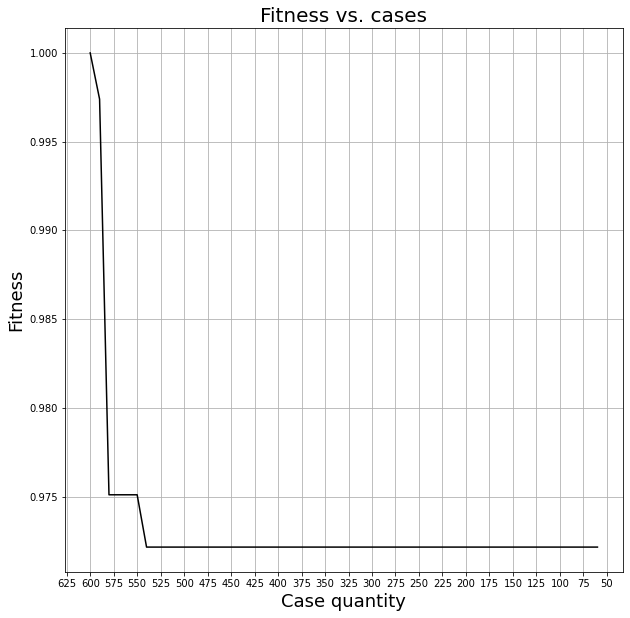

In [ ]:
# Tamanho da figura:
plt.figure(figsize=(10,10))
# Configuração dos parâmetros da linha:
plt.plot(n_cases_hist, fitness_hist, color = 'black')
# Título do gráfico:
plt.title('Fitness vs. cases', fontsize=20)
# Título do eixo "x":
plt.xlabel('Case quantity',fontsize=18)
# Título do eixo "y":
plt.ylabel('Fitness',fontsize=18)
# Escala de plotagem (linear, log, symlog, etc):
plt.yscale('linear')
# Inversão do eixo x (n_cases_hist) para correta projeção da redução de casos:
ax = plt.gca()
ax.invert_xaxis()
# Inserir grid ao gráfico:
plt.grid()
# Controle da resolução dos eixos (quantidade de 'thicks'):
ax.yaxis.set_major_locator(ticker.MultipleLocator(.005)) # Eixo 'y'.
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))   # Eixo 'x'.
# Visualização do gráfico:
plt.show()

#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/Fitness.png', transparent=True)

In [ ]:
# Plotando as listas com os dados do histórico de otimização:
# (Caso queira armazenar tabulado no Excel, para segurança)

print('Fitness history is:', fitness_hist)
print('Cases history is:', n_cases_hist)
print('acc_val history is:', acc_val_hist)
print('acc_test history is:', acc_test_hist)
print('Times history is:', time_hist)

Fitness history is: [1, 0.9973958134651184, 0.9751059412956238, 0.9751059412956238, 0.9751059412956238, 0.9751059412956238, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.9721590876579285, 0.97215908765792

In [ ]:
print(sum(time_hist))

9944.911436796188


**Referring to the last model that delivered test accuracy >= 95 %, the following graphs are available:**

* Training accuracy vs. training validation;

* Loss in training vs. loss in validation.

**Referring to the optimization history, the following graphs are available:**

* History of test accuracies vs. cases reduction;

* History of the max. validation accuracy (found in each round) vs. test accuracy (for each round).

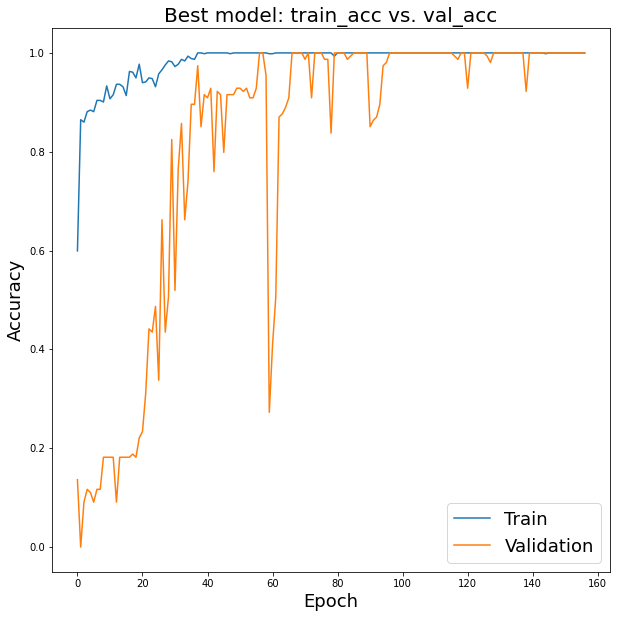

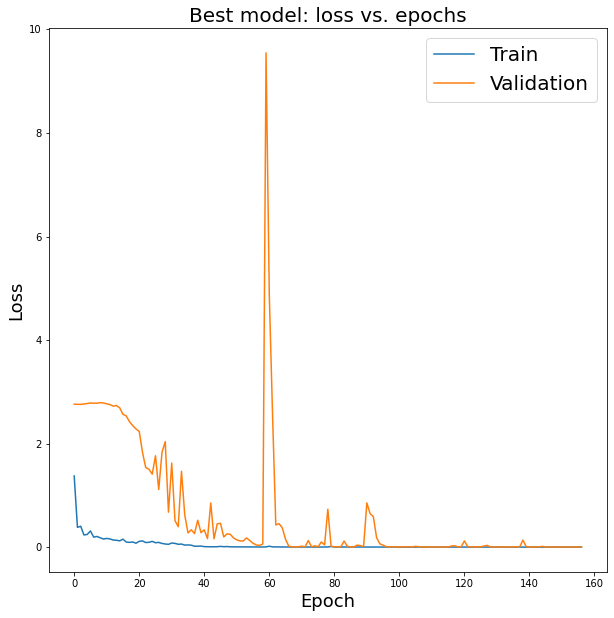

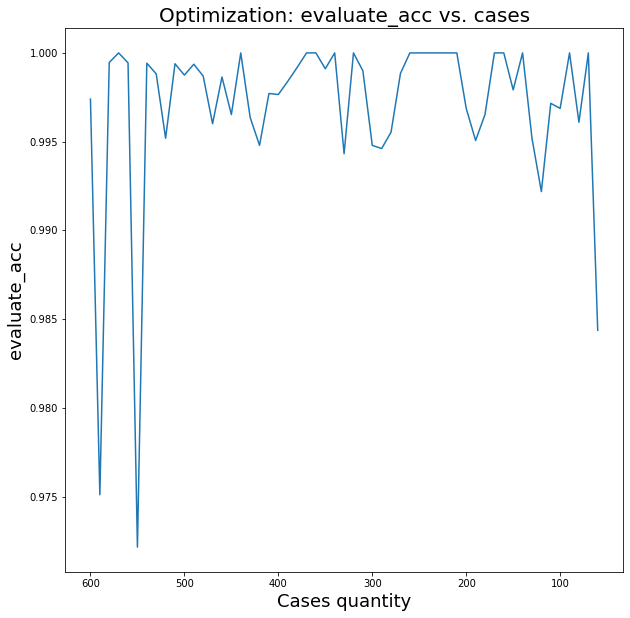

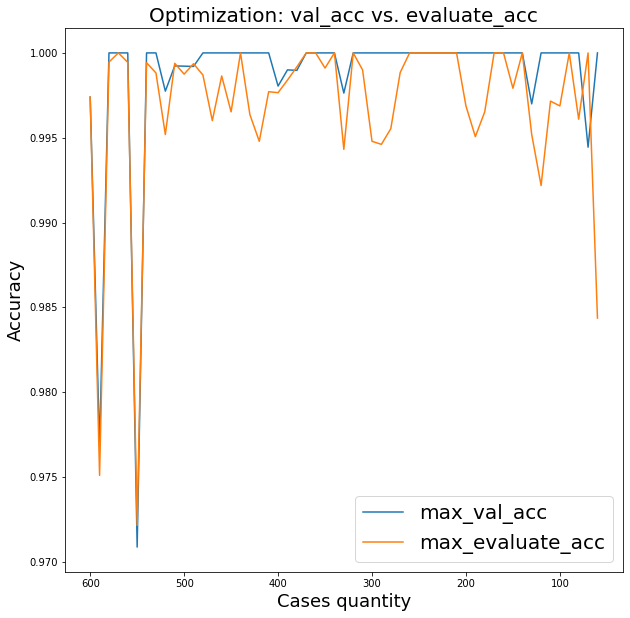

OPTIMIZATION SUMMARY:
-> The target accuracy configurated was: 95.00 %
-> The minimum number of cases computed above target accuracy was: 60 cases
-> (It represents 10.00 % from total dataset)

BEST MODEL SUMMARY:
-> BEST MODEL: Best validation accuracy found was: 100.0000 %
-> BEST MODEL: Test accuracy found was: 98.4375 %
-> BEST MODEL: It is a difference of 1.5625 %


In [ ]:
# -> ACURÁCIA:
# Tamanho da figura:
plt.figure(figsize=(10,10))
# Definição dos parâmetros que serão plotados:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# Título do gráfico:
plt.title('Best model: train_acc vs. val_acc', fontsize=20)
# Títulos dos labels:
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
# Título da legenda:
plt.legend(['Train', 'Validation'], loc='best', fontsize=18)
# Visualização do gráfico:
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/acctrainvsval.png', transparent=True)

# -> PERDA (LOSS):
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Best model: loss vs. epochs', fontsize=20)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Train', 'Validation'], loc='best', fontsize=20)
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/losstrainvsval.png', transparent=True)

# -> TESTE vs. REDUÇÃO DE CASOS:
plt.figure(figsize=(10,10))
line, = plt.plot(n_cases_hist, acc_test_hist)
plt.title('Optimization: evaluate_acc vs. cases', fontsize=20)
plt.xlabel('Cases quantity',fontsize=18)
plt.ylabel('evaluate_acc',fontsize=18)
plt.yscale('linear')
ax = plt.gca() # Inversão do eixo 'x'.
ax.invert_xaxis() # Inversão do eixo 'x'.
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/testvscasehist.png', transparent=True)

# -> HIST MÁX ACC VAL vs. HIST TESTE:
plt.figure(figsize=(10,10))
plt.plot(n_cases_hist, acc_val_hist)
plt.plot(n_cases_hist, acc_test_hist)
plt.title('Optimization: val_acc vs. evaluate_acc', fontsize=20)
plt.xlabel('Cases quantity',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend(['max_val_acc', 'max_evaluate_acc'], loc='best', fontsize=20)
plt.yscale('linear')
ax = plt.gca()
ax.invert_xaxis()
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/maxaccvalvstest.png', transparent=True)

# SUMÁRIO DOS RESULTADOS DO 1º ESTÁGIO:
print('OPTIMIZATION SUMMARY:')
# Acurácia configurada:
print('-> The target accuracy configurated was:',
      "%.2f" % round((acc_target*100),2),'%')

# Minimização de casos:
print('-> The minimum number of cases computed above target accuracy was:',
      n_cases_hist[-1],'cases')

# Porcentagem de redução do dataset:
print('-> (It represents',"%.2f" % round((((n_cases_hist[-1])/600)*100),2),
      '% from total dataset)')

print('\nBEST MODEL SUMMARY:')

# Melhor acurácia de validação encontrada no melhor modelo:
print('-> BEST MODEL: Best validation accuracy found was:',
      "%.4f" % round((acc_val_hist[-1]*100),4),'%')

# Melhor acurácia de teste encontrada no melhor modelo:
print('-> BEST MODEL: Test accuracy found was:',
      "%.4f" % round((acc_test_hist[-1])*100,4),'%')

# Diferença entre val_accuracy e test_accuracy:
print('-> BEST MODEL: It is a difference of',
      "%.4f" % round(((acc_val_hist[-1]*100)-(acc_test_hist[-1]*100)),4),'%')

#5.Independent test with the number of found cases

**This section is dedicated to the execution and analysis (duplicate test) of the solution (number of cases) found by the optimizer.**

* Observe that the experiment is based on a stochastic process, which hinders "perfect" reproducibility;
* Depending on the adjusted Reduction Step, the optimizer may offer a better "local" rather than better "global" solution.

In [ ]:
'''
Subset - lembrar de usar a mesma função de subset usada na otimização ("subset" ou "subsetB"):
"subset(Xt, Y, cases)" deve ser usado se o pré-processamento foi feito antes do subset;
"subsetB(cases)" faz o pré-processamento depois do subset.
'''

X_train, Y_train, X_val, Y_val, X_test, Y_test, n_cases = subsetB(600)

# Quando for rodar uma segunda vez, habilite o código abaixo:
#del modelx
#del modely
K.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

# Carregando o modelo padrão:
modelx = load_model(save_path)

# Treino e validação:
modely, history, acc_max, train_time = fit_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs)

# Teste:
test_accuracy = test_model(X_test, Y_test, modely)

Epoch 1/500
192/192 [==============================] - 3s 9ms/step - loss: 1.7595 - accuracy: 0.3992 - val_loss: 3.6366 - val_accuracy: 0.1165

Epoch 00001: val_accuracy improved from -inf to 0.11654, saving model to /content/drive/My Drive/Colab Notebooks/CargasEletricas/Vinicius/Dataset/modeled_current
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CargasEletricas/Vinicius/Dataset/modeled_current/assets
Epoch 2/500
192/192 [==============================] - 1s 7ms/step - loss: 0.9558 - accuracy: 0.5679 - val_loss: 5.8298 - val_accuracy: 0.1211

Epoch 00002: val_accuracy improved from 0.11654 to 0.12109, saving model to /content/drive/My Drive/Colab Notebooks/CargasEletricas/Vinicius/Dataset/modeled_current
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CargasEletricas/Vinicius/Dataset/modeled_current/assets
Epoch 3/500
192/192 [==============================] - 1s 7ms/step - loss: 0.6683 - accuracy: 0.7070 - val_loss: 4.6065 - v

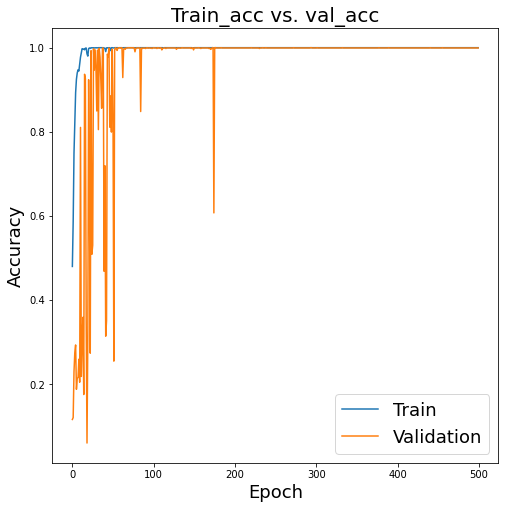

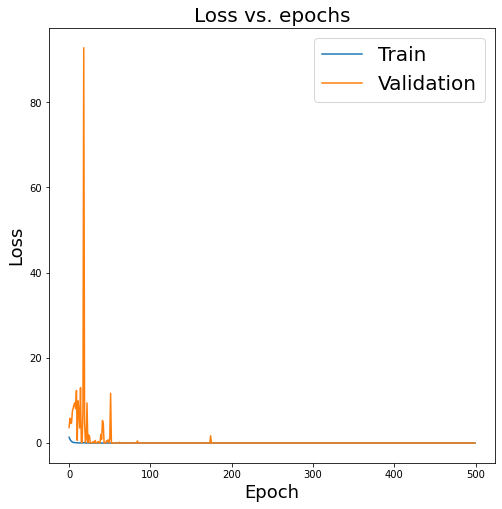

Max val_acc was: 1.0
Eval_acc was: 1.0


In [ ]:
# Acurácia:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train_acc vs. val_acc', fontsize=20)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend(['Train', 'Validation'], loc='best', fontsize=18)
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/trainacc_vs_valacc.png', transparent=True)

# Perda (loss):
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs', fontsize=20)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Train', 'Validation'], loc='best', fontsize=20)
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/trainloss_vs_valloss.png', transparent=True)

print('Max val_acc was:',acc_max)
print('Eval_acc was:',test_accuracy)

# 6.Second stage simulation (CNN hyperparameters)

**Briefly, the steps that make up the 2nd optimization stage are:**

* 6.1 Reduction of the database according to the 1st stage of optimization;
* 6.2 Definition of hyperparameters for adjustment and search space size;
* 6.3 CNN implementation with architecture that allows automatic adjustment;
* 6.4 Definition of fitness function;
* 6.5 Implementation of the Bayesian optimizer;
* 6.6 Plot the graphs with the optimization history.



## 6.1.Dataset reduction

Reduction will be the same as the identified on 1st stage:

In [ ]:
# Redução do nº de casos na base de dados (conforme resultado do 1º estágio):
X_train2, Y_train2, X_val2, Y_val2, X_test2, Y_test2, n_cases2 = subsetB(60)

## 6.2.Hyperparameters definition

Definition of the hyperparameters to adjust, the search space and the standard adjustment (required by the optimizer).

In [ ]:
# Definição do range de variação dos hiperparâmetros selecionados:
dim_num_conv_layers = Integer(low=2, high=4, name='num_conv_layers')
dim_num_conv_nodes = Integer(low=32, high=256, name='num_conv_nodes')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers') # Variando até 3 pois a última é de classificação, com ativador "Softmax".
dim_num_dense_nodes = Integer(low=16, high=256, name='num_dense_nodes')

# Definição do vetor que representa o espaço de busca do otimizador:
hp = [dim_num_conv_layers, dim_num_conv_nodes, dim_num_dense_layers, dim_num_dense_nodes]

# Definição do conjunto de hiperparâmetros padrão (requerido pelo otimizador):
default_parameters = [4, 128, 3, 256]

## 6.3.Model function (automodel)

Definition of new Callbacks parameters for the 2nd stage.

(EarlyStopping was configurated to stop CNN after 50 epochs without accuracy improvements)

In [ ]:
# EarlyStopping (O modelo pára o treinamento caso não perceba melhoria):
earlystopping2 = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=100,
                              verbose=1, mode="auto", baseline=None,
                              restore_best_weights=True)

# TensorDash (acompanhamento das métricas do modelo pelo app Android):
histories2 = Tensordash(ModelName = 'AutoML2', email = 'viniciuswv@gmail.com',
                       password = 'admin1')

Definition of the CNN function, with **dynamic architecture**.

(It's necessary to pass the selected hyperparameters)

In [ ]:
# Batch size (número de exemplos de treinamento usados em uma iteração/época):
batch_size = 32

# Épocas (quantidade de ciclos de treinamento da rede neural):
epochs = 500

def automodel (num_conv_layers, num_conv_nodes, num_dense_layers, num_dense_nodes):
  '''
  Hyperparameters:
  num_conv_layers: Number of convolutional layers.
  num_conv_nodes: Number of neurons in each convolutional layer,
  num_dense_layers: Number of dense layers.
  num_dense_nodes: Number of neurons in each dense layer.
  '''

  # Criação das camadas com apoio do recurso 'keras.sequential':
  model = Sequential() # Empilha linearmente as camadas da rede, conforme abaixo:
  
  # Camada de alimentação do dataset:
  model.add(InputLayer(input_shape=(1666,1))) # O tensor de entrada tem o shape (1666, 1).

  # Controle de camadas convolucionais (e MaxPooling/BatchNormalization):
  for i in range(num_conv_layers):
    name = 'layer_conv_{0}'.format(i+1) # Nome da camada.
    
    model.add(Conv1D(num_conv_nodes,
                     kernel_size=4,
                     strides=1,
                     activation='relu',
                     padding='same',
                     name=name))
    
    model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
    
    model.add(BatchNormalization())
  
  # Camada de achatamento (flatten):
  model.add(Flatten())
 
  # Controle de camadas densas (fully connected):
  for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1) # Nome da camada.
    model.add(Dense(num_dense_nodes, activation='relu', name=name))

  # Última camada densa (necessária para a classificação das features):
  model.add(Dense(16, activation='softmax'))

  # Programação da Taxa de Aprendizado (decaimento exponencial):
  lr_schedule2 = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-2,
  decay_steps=50,
  decay_rate=0.95)

  # Otimizador da rede:
  optimizer2 = tf.keras.optimizers.SGD(learning_rate= lr_schedule2, name="SGD")

  model.compile(loss= 'categorical_crossentropy',
                optimizer= optimizer2,
                metrics=['accuracy'])
 
  return model

##6.4.Fitness function

* The fitness function will call the dynamic CNN, that will train with a certain set of hyperparameters.

* The validation accuracy will be stored after each training season, and will be used as an evaluation criterion by the optimizer.

In [ ]:
# Método padrão para implementação da fitness function:
@use_named_args(dimensions=hp)
def fitness(num_conv_layers, num_conv_nodes, num_dense_layers, num_dense_nodes):
    
    # Visualização dos hiperparâmetros durante o processo de otimização:
    print('NEXT SET OF HYPERPARAMETERS IS:',
          '\n num_conv_layers:', num_conv_layers,
          '\n num_conv_nodes:', num_conv_nodes,   
          '\n num_dense_layers:', num_dense_layers,
          '\n num_dense_nodes:', num_dense_nodes,
          '\n')
    
    # Criação da CNN com os hiperparâmetros selecionados:
    model_opt = automodel(num_conv_layers=num_conv_layers,
                          num_conv_nodes=num_conv_nodes,
                          num_dense_layers=num_dense_layers,
                          num_dense_nodes=num_dense_nodes)

    # Aplicação do método "fit" para treinamento do modelo (CNN):
    history = model_opt.fit(X_train2,
                            Y_train2,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 1,
                            validation_data = (X_val2, Y_val2),
                            callbacks = [histories2, earlystopping2])

    # Armazenamento das métricas de validação após cada época:
    # (Pode escolher qual métrica será passada para o otimizador)
    # Se for a acurácia, fazer o 'return' com o valor negativo, pois o
    # otimizador utilizado só consegue minimizar o custo)
    accuracy = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1] # Custo a ser minimizado!

    # Visualização da acurácia durante o processo de otimização:
    print('\nAccuracy: {0:.2%}'.format(accuracy))
    
    # Visualização da perda (loss) durante o processo de otimização:
    print('Loss:', loss, '\n')
    
    # Exclusão dos dados do modelo Keras (com os hiperparâmetros) da memória:
    # (Evitar que a rede "aprenda" de uma rodada para outra)
    del model_opt
    K.clear_session()
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    return loss

## 6.5.Bayesian optimizer

Implementation of Bayesian optimization (from Scikit-optimize) using Gaussian Processes:

In [ ]:
# Implementação de um callback para monitorar tempo:
TimerCallback = skopt.callbacks.TimerCallback()

# Implementação de um callback para salvar cada iteração:
# (Consultar a documentação caso necessário carregar o processo "load")
checkpoint_saver = CheckpointSaver("./checkpoint.pkl")

# Instanciamento do otimizador:
result = gp_minimize(func= fitness,
                     dimensions= hp,
                     acq_func='EI', # Função de aquisição (VIANNA, 2021).
                     n_calls= 100,    # Número de iterações do otimizador!
                     x0= default_parameters,
                     callback= [TimerCallback, checkpoint_saver])

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 117/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0208 - accuracy: 0.9891 - val_loss: 0.1954 - val_accuracy: 0.8961
Epoch 118/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1162 - val_accuracy: 0.9156
Epoch 119/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1651 - val_accuracy: 0.8961
Epoch 120/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 121/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9286
Epoch 122/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9935
Epoch 123/500
20/20 [==============================] - 0s 9ms/step - loss: 0.00

## 6.6.Second stage results

**Results of the 2nd stage of optimization:**
*  Convergence plot (visualization of the fitness function after *n* iterations of the optimizer);
*  Objective plot (visualization of the influence of each search-space dimension on the objective function);
*  The history of analyzed hyperparameters sets;
*  The time spent in the optimization process.

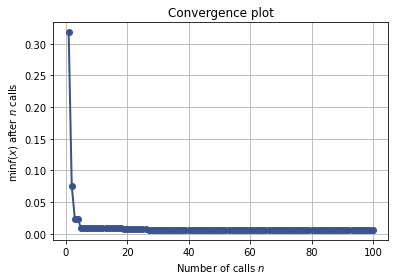

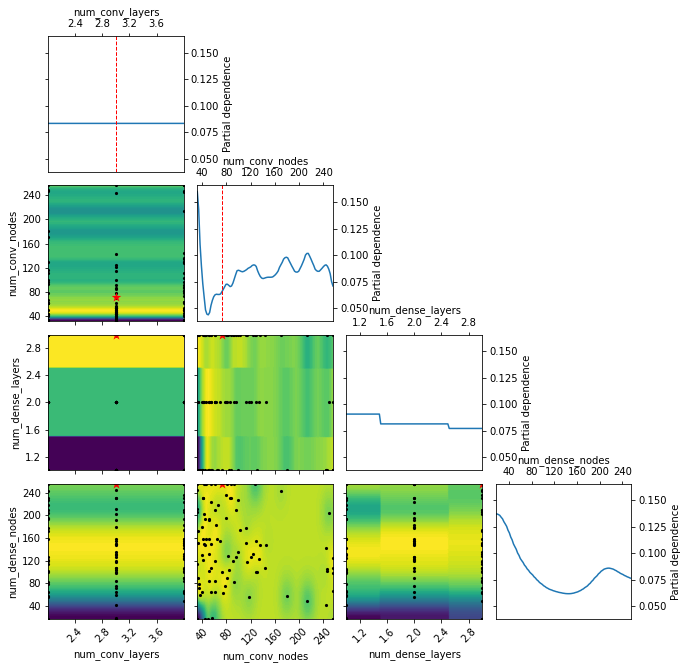

In [ ]:
# Visualização das métricas:

skopt.plots.plot_convergence(result)
plt.savefig('/content/drive/My Drive/MESTRADO - UFES/optimizer convergence A1_0.png', transparent=True, bbox_inches='tight', dpi=600)


skopt.plots.plot_objective(result,
                           levels=100,
                           n_points=100,
                           n_samples=250,
                           size=2.25,
                           zscale='linear',
                           dimensions=None,
                           sample_source='random',
                           minimum='result',
                           n_minimum_search=None,
                           plot_dims=None,
                           show_points=True,
                           cmap='viridis_r')
plt.savefig('/content/drive/My Drive/MESTRADO - UFES/space exploration A1_0.png', transparent=True, bbox_inches='tight', dpi=600)

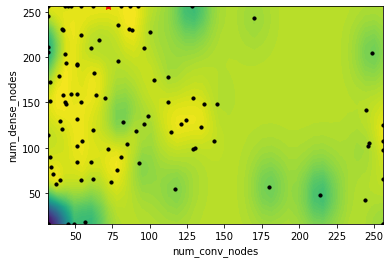

In [ ]:
# Caso necessário uma superfície de contorno ampliada, comparando a exploração
# de dois hiperparâmetros específicos com a função de custo: 

skopt.plots.plot_objective_2D(result,
                              dimension_identifier1='num_conv_nodes',
                              dimension_identifier2='num_dense_nodes',
                              levels=100)
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/objective_2D A1_0.png', transparent=True, bbox_inches='tight', dpi=600)

The history of the optimization process is shown below:

In [ ]:
print('Hyperparameters: num_conv_layers / num_conv_nodes / num_dense_layers / num_dense_nodes')

for fitness, x in sorted(zip(result.func_vals, result.x_iters)):
    print('The fitness was:', fitness, 'with hyperparameters:', x)

Hyperparameters: num_conv_layers / num_conv_nodes / num_dense_layers / num_dense_nodes
The fitness was: 0.006251691374927759 with hyperparameters: [3, 72, 3, 256]
The fitness was: 0.00643661804497242 with hyperparameters: [4, 87, 3, 256]
The fitness was: 0.0065511008724570274 with hyperparameters: [3, 39, 2, 179]
The fitness was: 0.007027422543615103 with hyperparameters: [3, 86, 2, 231]
The fitness was: 0.00744587043300271 with hyperparameters: [3, 91, 3, 119]
The fitness was: 0.007887057028710842 with hyperparameters: [3, 54, 3, 64]
The fitness was: 0.007935186848044395 with hyperparameters: [4, 63, 2, 183]
The fitness was: 0.008070768788456917 with hyperparameters: [4, 64, 1, 158]
The fitness was: 0.00810674112290144 with hyperparameters: [3, 51, 3, 84]
The fitness was: 0.008513066917657852 with hyperparameters: [3, 54, 2, 150]
The fitness was: 0.00870724767446518 with hyperparameters: [3, 114, 3, 117]
The fitness was: 0.008789333514869213 with hyperparameters: [3, 121, 2, 126]
The 

The best hyperparameter set (according to the optimizer) it's shown below:

In [ ]:
# Resumo da busca, segundo o otimizador:
print('Best fitness: %.4f' % (result.fun))
print('Best hyperparameters: %s' % (result.x))

Best fitness: 0.0063
Best hyperparameters: [3, 72, 3, 256]


The amount of time spent in the 2nd stage of optimization it's shown below:

In [ ]:
# Atributo "iter_time" evidencia o tempo (s) de cada iteração:
times = TimerCallback.iter_time
print('The time of each iteration is:', times)
print('\nThe total time spent in this optimization was:', sum(times), 'seconds.')

The time of each iteration is: [113.57223463058472, 139.73756790161133, 110.67989659309387, 128.61989045143127, 120.44724678993225, 136.8393943309784, 152.36987257003784, 132.76317286491394, 117.91383290290833, 108.65076804161072, 167.4773509502411, 129.90924429893494, 101.64388418197632, 105.4949083328247, 95.34290528297424, 101.41025185585022, 111.50186920166016, 101.0194878578186, 120.33346509933472, 109.18593955039978, 120.62126231193542, 112.61713719367981, 105.69915890693665, 104.58468413352966, 130.4757535457611, 102.79886722564697, 123.77045845985413, 137.0669023990631, 104.83707618713379, 136.22201108932495, 105.75375723838806, 135.37232661247253, 133.14984273910522, 123.54477190971375, 98.95598220825195, 120.83720064163208, 117.39332294464111, 115.13914489746094, 101.52633738517761, 113.09741377830505, 129.40614700317383, 113.23984408378601, 115.5126519203186, 96.0610704421997, 96.58389711380005, 132.51911783218384, 112.8084979057312, 127.33247804641724, 129.8900797367096, 13

# 7.Independent test with the hyperparameters found set

**This section is dedicated to the execution and analysis (duplicate test) of the solution (set of hyperparameters) found by the 2nd optimizer.**

* Observe that the experiment is based on a stochastic process, which hinders "perfect" reproducibility.
* Accuracy/Loss plots and confusion matrix were implemented to verify the performance of the model found.

In [ ]:
# EarlyStopping (O modelo pára o treinamento caso não perceba melhoria):
earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=100,
                              verbose=1, mode="auto", baseline=None,
                              restore_best_weights=True)

# TensorDash (acompanhamento das métricas do modelo pelo app Android):
histories = Tensordash(ModelName = 'AutoML', email = 'viniciuswv@gmail.com',
                       password = 'admin1')

# Batch size (número de exemplos de treinamento usados em uma iteração/época):
batch_size = 32

# Épocas (quantidade de ciclos de treinamento da rede neural):
epochs = 500

**Function that creates the final architecture (like optimized on 2nd stage):**
* (Before running the function, adjust the number of convolutional and dense layers, as well as their respective neurons)

In [ ]:
def final_model():
  # Criação das camadas com apoio do recurso 'keras.sequential':
  model = Sequential() # Empilha linearmente as camadas da rede, conforme abaixo:
  # Camada de alimentação do dataset:
  model.add(InputLayer(input_shape=(1666,1))) # O tensor de entrada tem o shape (1666, 1).
 
  # 1ª camada convolucional:
  model.add(Conv1D(72, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 1ª camada MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 1ª camada de normalização do batch:
  model.add(BatchNormalization())
  
  # 2ª camada convolucional:
  model.add(Conv1D(72, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 2ª camada MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 2ª camada de normalização do batch:
  model.add(BatchNormalization())
 
  # 3ª camada convolucional:
  model.add(Conv1D(72, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 3ª camada de MaxPooling:
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 3ª camada de normalização do batch:
  model.add(BatchNormalization())
  
  # 4ª camada convolucional:
  #model.add(Conv1D(232, kernel_size=4, strides=1, activation='relu', padding='same'))
  # 4ª camada de MaxPooling:
  #model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
  # 4ª camada de normalização do batch:
  #model.add(BatchNormalization())
  
  # Camada de achatamento (flatten):
  model.add(Flatten())
  
  # 1ª camada densa (fully connected):
  model.add(Dense(256, activation='relu'))
  # 2ª camada densa (fully connected):
  model.add(Dense(256, activation='relu'))
  #3ª camada densa (fully connected):
  model.add(Dense(256, activation='relu'))
  # 4ª camada densa (fully connected):
  model.add(Dense(16, activation='softmax'))

  model.summary()

  # Programação da Taxa de Aprendizado (decaimento exponencial):
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-2,
  decay_steps=50,
  decay_rate=0.95)

  # Otimizador da rede:
  optimizer = tf.keras.optimizers.SGD(learning_rate= lr_schedule, name="SGD")


  # Compilação do modelo neural:
  model.compile(loss='categorical_crossentropy',
                optimizer= optimizer,
                metrics=['accuracy'])
  return model

Passing the necessary functions to subset data, train and evaluate the final model:

In [ ]:
# Subset - lembrar de usar o mesmo subset usado no 1º estágio de otimização:
X_train3, Y_train3, X_val3, Y_val3, X_test3, Y_test3, n_cases3 = subsetB(60)

# Quando for rodar uma segunda vez, habilite o código abaixo:
#del cnn
#del final_model
K.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

# Instanciando a nova CNN:
cnn = final_model()

# Treino e validação:
final_model, history3, acc_max3, train_time3 = fit_model(cnn,
                                                         X_train3,
                                                         Y_train3,
                                                         X_val3,
                                                         Y_val3,
                                                         batch_size,
                                                         epochs)

# Teste:
test_accuracy = test_model(X_test3, Y_test3, final_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1666, 72)          360       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 555, 72)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 555, 72)           288       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 555, 72)           20808     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 185, 72)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 185, 72)           288       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 185, 72)           2

Plotting the results from the final model:

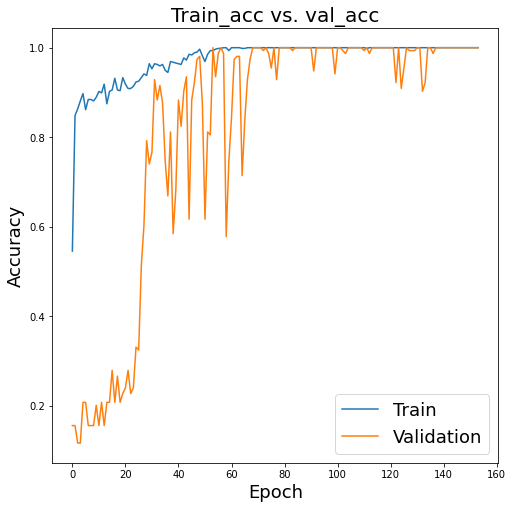

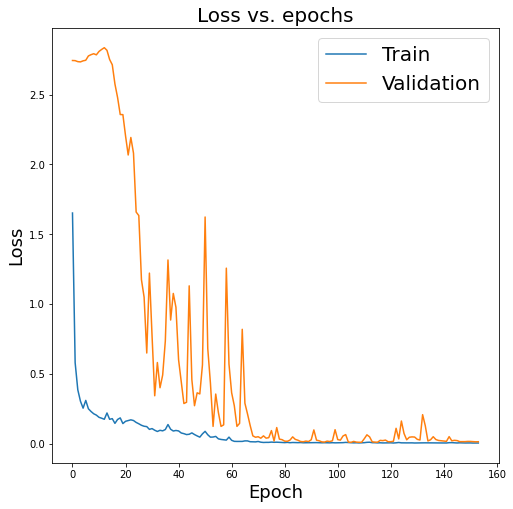

Max val_acc was: 1.0
Eval_acc was: 1.0


In [ ]:
# Acurácia:
plt.figure(figsize=(8,8))
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Train_acc vs. val_acc', fontsize=20)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend(['Train', 'Validation'], loc='best', fontsize=18)
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/trainacc_vs_valacc.png', transparent=True)

# Perda (loss):
plt.figure(figsize=(8,8))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs', fontsize=20)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Train', 'Validation'], loc='best', fontsize=20)
plt.show()
#Para salvar no Drive...
#plt.savefig('/content/drive/My Drive/MESTRADO - UFES/trainloss_vs_valloss.png', transparent=True)

print('Max val_acc was:',acc_max3)
print('Eval_acc was:',test_accuracy)

Function that creates the **confusion matrix**:

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize= 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Correta', fontsize=18)
    plt.xlabel('Classe Predita', fontsize=18)

The **confusion matrix** of test data it's shown below:

Confusion matrix, without normalization
[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0.

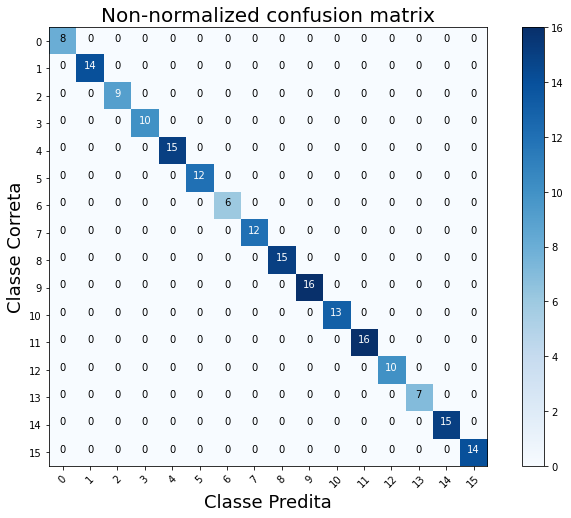

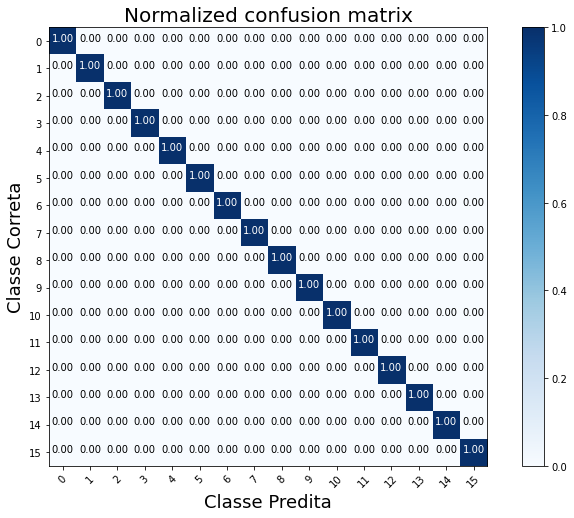

In [ ]:
y_test_pred = final_model.predict(X_test3)

# "Desbinarização" dos labels:
# (Labels estão binarizados; matriz de confusão não aceita)
Y_test_non_category = [np.argmax(t) for t in Y_test3]
y_test_pred_non_category = [np.argmax(t) for t in y_test_pred]

cnf_matrix = confusion_matrix(Y_test_non_category, y_test_pred_non_category)
class_names = np.arange(0,16)

# Matriz de confusão não normalizada:
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Non-normalized confusion matrix')

# Matriz de confusão normalizada:
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')